## 2.9 Feature engineering


The process of feature engineering is of manipulating, transforming, and selecting raw data into features that can be used in statistical analysis of prediction.

* statistical features
* temporal features
* spectral features (Fourier and Wavelet transforms)

This lecture will demonstrate how to automatically extract features from a popular (but simple) Python package ``tsfel`` to extract common features of time series. We will take the example of seismic waveforms recorded in the Pacific Northwest. The Pacific Northwest data detect and labels seismic waveforms for event of various origins: earthquake, explosions (mostly quarry blasts), and surface events (usually avalanches and landslides), but also seismic noise (ambient Earth vibrations in between).

We will explore how these features vary among the four categories, or classes of seismic events.

[Level 1]

In [1]:
# Import modules for seismic data and feature extraction

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as st
import os
import h5py # for reading .h5 files

In [2]:
#make sure to install wget
!pip install wget
import wget

  Using cached wget-3.2-py3-none-any.whl


We download 2 files from the class storage: a CSV file with the waveforms themselves as an HDF5 file and their associated metadata as a CSV file:

In [3]:
wget.download("https://www.dropbox.com/s/f0e1ywupdbuv3l3/miniPNW_metadata.csv?dl=1")
wget.download("https://www.dropbox.com/s/0ffh4r23mitn2dz/miniPNW_waveforms.hdf5?dl=1")

'miniPNW_waveforms (1).hdf5'

## Metadata

We first read the metadata and arange them into a Pandas Data frame

In [4]:
# plot the time series
df = pd.read_csv("miniPNW_metadata.csv")
df.head()


,Unnamed: 0,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,...,trace_S_onset,trace_P_onset,trace_snr_db,year,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude
0,0,uw61669232,2020-09-07T03:44:14.690000Z,46.560,-119.797,earthquake,23.300,1.30,ml,0.241000,...,impulsive,impulsive,-1.444|2.612|9.921,2020.0,eq,1.30,0.241273,1.17,0.187840,NaN
1,1,uw60888282,2014-10-08T15:39:31.330000Z,45.371,-121.708,earthquake,-0.947,1.67,ml,0.128000,...,impulsive,impulsive,0.368|3.526|5.981,2014.0,eq,1.67,0.128000,1.63,0.099000,NaN
2,2,uw61361706,2017-12-30T04:37:46.870000Z,46.165,-120.543,earthquake,13.520,2.46,ml,0.158000,...,impulsive,emergent,11.274|13.32|15.828,2017.0,eq,2.46,0.158000,3.37,0.389000,NaN
3,3,uw61639436,2020-06-09T23:37:10.420000Z,46.542,-119.589,earthquake,16.370,1.59,ml,0.157000,...,impulsive,emergent,27.007|20.797|19.252,2020.0,eq,1.59,0.156750,1.69,0.354773,NaN
4,4,uw61735446,2021-05-24T10:42:37.810000Z,46.857,-121.941,earthquake,12.380,0.83,ml,0.082983,...,impulsive,emergent,18.579|18.912|7.609,2021.0,eq,0.83,0.082983,0.50,0.381880,NaN


The nature of the event source is located in one of the metadata attributes

In [5]:
df['source_type'].unique()

array(['earthquake', 'explosion', 'sonic_boom', 'thunder',
       'surface_event'], dtype=object)

Let's assume that we are exploring features to classify the waveforms into the categories of the event types. We will attribute the **labels* as the ``source_type`` attribute.

In [6]:
labels=df['source_type']

How many seismic waveforms are there in each of the category?

In [ ]:
##

Would you say that this is a balanced data set with respect to the four classes of interest?

Now we will look at the seismic data, taking a random waveform from each of the categories

(array([500.,   0., 500.,   0.,   0., 126.,   0.,  94.,   0., 500.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

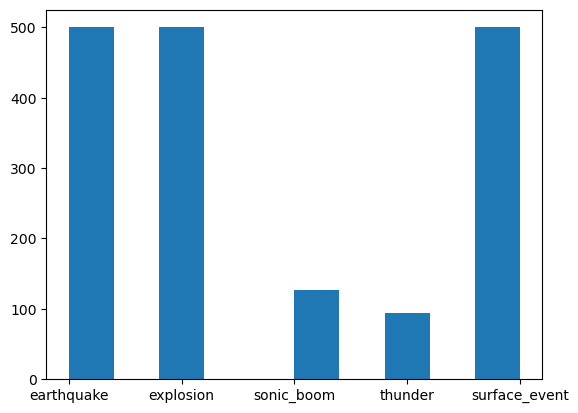

In [7]:
plt.hist(labels)

Now are read the data. It is stored in an HDF5 files under a finite number of groups. Each groups has an array of datasets that correspond to the waveforms. To link the metadata to the waveform files, the key trace_name has the dataset ID. The address is labeled as follows:
```
bucketX$i,:3,:n
```

where ``X`` is the HDF5 group number, ``i`` is the index. The file has typically 3 waveforms from each direction of ground motions N, E, Z. In the following exercise, we will focus on the vertical waveforms.

In [8]:
f = h5py.File("miniPNW_waveforms.hdf5", "r")

Below a function to read the file in the data

In [9]:
def read_data(tn,f):
    bucket, narray = tn.split('$')  # split the string of trace_name into bucket and narray
    x, y, z = iter([int(i) for i in narray.split(',:')]) # split thenarray into x, y, z
    data = f['/data/%s' % bucket][x, :y, :z] # read the data as a 3D array
    return data

The trace name is stored as data attriobute in the metadata.

In [10]:
ldata=list(df['trace_name'])

(3, 15001)


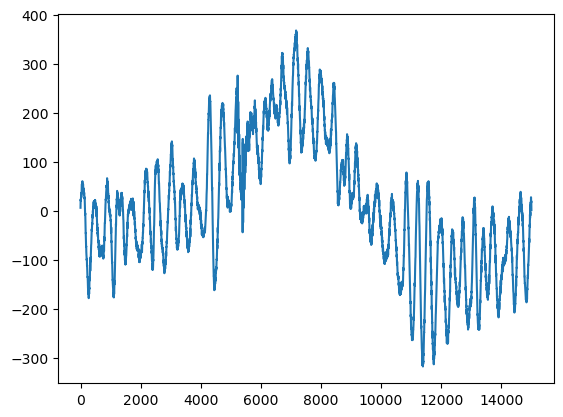

In [11]:
crap=read_data(ldata[400],f)
print(crap.shape)
plt.plot(crap[1,:])

We will just extract the Z component and reshape them into a single array.

In [12]:
nt=crap.shape[-1]
ndata=len(labels)
Z=np.zeros(shape=(ndata,nt))
for i in range(ndata-1):
    Z[i,:]=read_data(df.iloc[i]["trace_name"],f)[2,:nt]

Now we have data and its attributes, in particular the label as source type.

We are going to extract features automatically from tsfel and explore how varied the

In [13]:
!pip install tsfel
import tsfel

We need to format for input into tsfresh. It needs 1 column with the ``id`` (or label), one column for the time stamps (``sort``)

In [14]:
cfg = tsfel.get_features_by_domain()     

In [15]:
Z.shape

(1720, 15001)

In [ ]:
for i in range(Z.shape[0]):
    print(i/Z.shape[0])
    if i==0:
        X=tsfel.time_series_features_extractor(cfg, Z[i,:],fs=100.,)
        X['source_type']=df.iloc[i]['source_type']
    else:
        XX = tsfel.time_series_features_extractor(cfg, Z[i,:],fs=100.,)
        XX['source_type']=df.iloc[i]['source_type']
        X=pd.concat([XX,X],axis=0,ignore_index=True)


In [ ]:
X.head()

## Exploring the feature space

Here we will plot distributions of features among the four classes. And we will explore what features are most correlated with each others in each of the categories.


In [ ]:
plt.hist(np.log10(X['0_Wavelet variance_1']));

In [ ]:
plt.matshow(X.drop('source_type',axis=1).corr(),cmap='seismic',vmin=-1,vmax=1)

Now calculate features for 100 events of each category and find features that differ from each other.

You may 1) calculate all features, 2) plot histograms/distributions of each feature and overlay each source-specific feature, 3) report on the ones that look different between each class and propose a workflow to classify between event types.